In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde

def _kde(x, y, nbins):
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    return xi, yi, zi

def pairwise(samples, parameter_names=None, title=None, saveto=None, nbins=100):

    sns.set_context("paper", font_scale=1)
    sns.set(rc={"figure.figsize":(9,11),"font.size":25,"axes.titlesize":25,"axes.labelsize":25,
           "xtick.labelsize":25, "ytick.labelsize":25},style="white")

    _, n_param = samples.shape
    fig_size = (3 * n_param, 3 * n_param)
    fig, axes = plt.subplots(n_param, n_param, figsize=fig_size)
  
    for i in range(n_param):
        for j in range(n_param):
            if i == j:
                axes[i, j].axis('off')

            elif i < j:
                axes[i, j].axis('off')

            else:
                x, y, z =_kde(samples[:, j], samples[:, i], nbins)
                axes[i,j].pcolormesh(x, y, z.reshape(x.shape))    
            
            if i < n_param - 1:
                axes[i, j].set_xticklabels([])
            else:
                for tl in axes[i, j].get_xticklabels():
                    tl.set_rotation(45)

            if j > 0:
                axes[i, j].set_yticklabels([])

        if parameter_names is not None:
            axes[-1, i].set_xlabel(parameter_names[i])
            
        else:
            axes[-1, i].set_xlabel('Parameter %d' % (i + 1))
        if i == 0:
            axes[i, 0].set_ylabel('Frequency')
        else:
            if parameter_names is not None:
                axes[i, 0].set_ylabel(parameter_names[i])
            else:
                axes[i, 0].set_ylabel('Parameter %d' % (i + 1))
    if title is not None:
        fig.suptitle(title,fontsize=40)
    fig.tight_layout()
    fig.subplots_adjust(top=1.05)
    
    if saveto is not None:
        plt.savefig(saveto, dpi=250)
    
    return fig, axes

In [8]:
import pip
!pip3 install pyro-ppl

     |████████████████████████████████| 634kB 5.9MB/s 


In [9]:
import sympy as sym
sym.init_printing()

import numpy as np
from scipy.integrate import odeint
# from plot_pairwise import pairwise

import torch
from torch.autograd import Function
import torch.nn as nn
import pyro
from pyro.nn import PyroSample
from pyro.nn import PyroModule
import pyro.distributions as dist
from pyro.infer.autoguide import AutoMultivariateNormal

from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import AdagradRMSProp
import matplotlib.pyplot as plt
%matplotlib inline

### Define the base class for ode solving with forward sensitivity

In [10]:
class OdeSolverForwardSens(object):
    def __init__(self):
        super(OdeSolverForwardSens, self).__init__()

    def _rhs(self, y, t, p):
        raise NotImplementedError
    
    def _jac_y(self, y):
        raise NotImplementedError
    
    def _jac_p(self, y):
        raise NotImplementedError
    
    def solve(self, parameters):
        return self._solve(parameters, False)

    def solve_with_sensitivities(self, parameters):
        return self._solve(parameters, True)

    def _solve(self, parameters, sensitivities):

        if sensitivities:
            self._params = parameters           
            
            def augmented_ode(y_and_dydp, t, p):
                
                y = y_and_dydp[0:self._n_states]
                dydp = y_and_dydp[self._n_states:].reshape((
                    self._n_states, self._n_params))
                dydt = self._rhs(y, t, p)
                d_dydp_dt = np.matmul(self._jac_x(y, p), dydp) + self._jac_p(y, p)
                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))            
            y0 = np.zeros(self._n_states + (self._n_states * self._n_params))
            y0[0:self._n_states] = self._y0
            result = odeint(augmented_ode, y0, self._times, (parameters,), 
                            rtol=self._rtol, atol=self._atol)
            x = result[:, 0:self._n_states]
            dx_dp = result[:, self._n_states:].reshape((
                len(times), self._n_states, self._n_params))
            return x, dx_dp
        else:
            self._params = parameters
            x = odeint(self._rhs, self._y0, self._times, (parameters,),
                            rtol=self._rtol, atol=self._atol)
            
            return x              

## The ODE velocity field

In [11]:
def r(y, t, p):
    X1, X2, X3=y
    a1, a2, alpha, k1, k2 = p
    dX1_dt = (a1/( 1 + (a2*(X3**10)) ) ) - (alpha*X1);
    dX2_dt = (k1*X1) - (alpha*X2);
    dX3_dt = (k2*X2) - (alpha*X3);
    return dX1_dt,dX2_dt,dX3_dt


## Now use `SymPy` for all expressions of Jacobians

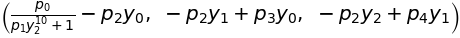

In [12]:
y, p = sym.symbols('y:3'), sym.symbols('p:5')
ydot = r(y, None, p)
ydot

In [13]:
t = sym.symbols('t')  # not used in this case.
rhs_f = sym.lambdify((y, t, p), ydot)  # EXERCISE: (y, t) + k

In [14]:
jac_x = sym.Matrix(ydot).jacobian(y)
jac_x

⎡                      9 ⎤
⎢          -10⋅p₀⋅p₁⋅y₂  ⎥
⎢-p₂   0   ──────────────⎥
⎢                       2⎥
⎢          ⎛     10    ⎞ ⎥
⎢          ⎝p₁⋅y₂   + 1⎠ ⎥
⎢                        ⎥
⎢p₃   -p₂        0       ⎥
⎢                        ⎥
⎣ 0   p₄        -p₂      ⎦

In [15]:
jac_p = sym.Matrix(ydot).jacobian(p)
jac_p

⎡                     10                 ⎤
⎢     1         -p₀⋅y₂                   ⎥
⎢───────────  ──────────────  -y₀  0   0 ⎥
⎢     10                   2             ⎥
⎢p₁⋅y₂   + 1  ⎛     10    ⎞              ⎥
⎢             ⎝p₁⋅y₂   + 1⎠              ⎥
⎢                                        ⎥
⎢     0             0         -y₁  y₀  0 ⎥
⎢                                        ⎥
⎣     0             0         -y₂  0   y₁⎦

In [16]:
jac_x_f = sym.lambdify((y, p), jac_x)
jac_p_f = sym.lambdify((y, p), jac_p)

## Extend the class above and pass in the `Lambdas`

In [17]:
class GoodwinModel(OdeSolverForwardSens):
    
    def __init__(self, _rhs_f, _jac_x_f, _jac_p_f, n_states, n_params, times,
                 rtol=1e-5, atol=1e-6, y0=None):
        super(GoodwinModel, self).__init__()
               
        if y0 is None:
            self._y0 = np.array(np.zeros(n_states), dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float) 
        self._rhs_f = _rhs_f
        self._jac_x_f = _jac_x_f
        self._jac_p_f = _jac_p_f
        
        self._n_states = n_states
        self._n_params = n_params
        self._times = times
        self._T = len(times)
        self._rtol = rtol
        self._atol = atol  

        
    def _rhs(self, y, t, p):
        return self._rhs_f(y, t, p)

    def _jac_x(self, y, p):
        return self._jac_x_f(y, p)

    def _jac_p(self, y, p):
        return self._jac_p_f(y, p)

## Simulate fake data

Text(0, 0.5, 'Value')

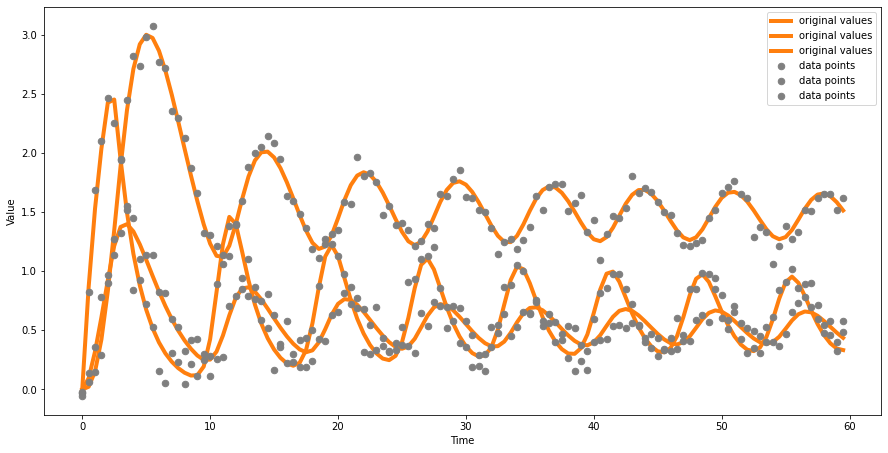

In [18]:
times = np.arange(0,60, 0.5)
gw_ode_model = GoodwinModel(rhs_f, jac_x_f, jac_p_f, 3, 5, times, 1e-5, 1e-6, [0,0,0]);
sigma=0.1
real_params = [1.97,0.15,0.53,0.46,1.49]
sol=gw_ode_model.solve(real_params)
np.random.seed(121) #np.random.seed(111)
Y=sol+np.random.randn(120,3)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='original values')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')

## Custom ODE op

Note that we now write the custom op slightly differently to pass the ode solver object.

In [ ]:
class ODEop(Function):  
    @staticmethod
    def forward(ctx, params, model): 
        numpy_params = params.detach().numpy() 
        sol, Jac = model.solve_with_sensitivities(numpy_params)
        ctx.T, ctx.k, ctx.d = model._T, model._n_states, model._n_params
        ctx.save_for_backward(torch.as_tensor(Jac, dtype=params.dtype))
        return torch.as_tensor(sol, dtype=params.dtype)

    @staticmethod
    def backward(ctx, grad_output):
        T = ctx.T
        d = ctx.d
        k = ctx.k
        bJac = ctx.saved_tensors[0]
        numpy_Jac = bJac.detach().numpy().reshape((k*T,d))
        v = grad_output.detach().numpy()
        vjp = numpy_Jac.T.dot(v.reshape(k*T))
        return grad_output.new(torch.as_tensor(vjp)), None #<----Since the second input is the ode_model object

## Define the Generative model

In [ ]:
from pyro.nn import PyroSample
from pyro.nn import PyroModule

class GoodwinGenModel(PyroModule):
    def __init__(self, ode_model):        
        super(GoodwinGenModel, self).__init__()
        self._ode_model = ode_model
        self.ode_params = PyroSample(dist.Gamma(
            torch.tensor([2.0,2.0,2.0,2.0,2.0]),1.0).to_event(1) )      
        
    def forward(self, data): 
        
        scale = pyro.sample("scale", dist.HalfNormal(1.0))
        states = ODEop.apply(self.ode_params, self._ode_model)
        with pyro.plate("map", len(data)):

            pyro.sample("obs",
                        dist.Normal(states, scale).to_event(1),
                        obs=data)
            return states


## Define the variational approximation

In [ ]:
y_torch = torch.tensor(Y,dtype=torch.float)
model = GoodwinGenModel(gw_ode_model)
guide = AutoMultivariateNormal(model)

In [ ]:
pyro.set_rng_seed(121)
pyro.clear_param_store()
optim = AdagradRMSProp({"eta": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=1))

## Maximise the ELBO

In [ ]:
def train():
    loss_trace = []
    for j in range(30000):
        loss = svi.step(y_torch)
        loss_trace.append(loss)

        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, np.mean(loss_trace[-100:])))
    return loss_trace

In [ ]:
loss_graph = train()
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))


In [ ]:
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("ode_params", "scale", "obs", "_RETURN"))
vb_ppc_samples = predictive(y_torch)

In [ ]:
vb_params=np.concatenate((vb_ppc_samples['ode_params'].detach().numpy().reshape((1000,5))
                          ,vb_ppc_samples['scale'].detach().numpy()),axis=1)

In [ ]:
param_names = [r"$a_1$", r"$a_2$", r"$\alpha$", r"$k_1$", r"$k_2$", r"$\sigma_x$"]
real_params.append(0.1)
for i, p in enumerate(param_names):
        
        plt.subplot(3, 2, i+1)
        plt.axvline(real_params[i], linewidth=2.5, color='black')
        if i==0:
            sns.kdeplot(vb_params[:, i], color='magenta', linewidth = 2.5, label='Variational')
        else:
            sns.kdeplot(vb_params[:, i], linewidth = 2.5, color='magenta')
            
        if i%2==0:
            plt.ylabel('Frequency')
        plt.xlabel(param_names[i])        
        if i<1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower center', ncol=2,fontsize=18)
plt.subplots_adjust(hspace=0.7)
plt.tight_layout()

## TODO: arviz for plotting